**Importing required libraries**

In [23]:
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

# Libraries for Word Cloud Process
import collections
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Retrieve Dataset as Dataframe from CSV file:**

In [24]:
df = pd.read_csv("/content/Poem_Data.csv")

**Data Pre-processing:**

In [25]:
# check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


**checking null values in Dataframe**

In [26]:
df.isnull().sum()

Genre    0
Poem     4
dtype: int64

**Drop Null values from the Dataframe**

In [27]:
df = df.dropna()

**Label Encoding the Genre Column**

In [28]:
df['Genre'] = df['Genre'].map({'Affection':0, 'Death':1, 'Environment':2, 'Music':3})

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 1 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   837 non-null    int64 
 1   Poem    837 non-null    object
dtypes: int64(1), object(1)
memory usage: 19.6+ KB


In [30]:
# Setting this so we can see the full content of cells
pd.set_option('display.max_colwidth', None)
# to make sure we can see all the columns in output window
pd.set_option('display.max_columns', None)

**Function for cleaning the poem column**

In [31]:
# Cleaning poem
def cleaner(poem):
    # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    soup = BeautifulSoup(poem, 'lxml')
    souped = soup.get_text()
    # substituting hashtags, @mentions, urls, etc with whitespace
    re1 = re.sub(r"(#|@|http://|https://|www)\S*", " ", souped)
    # substituting any non-alphabetic character that repeats one or more times with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1)

    tokens = nltk.word_tokenize(re2)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [32]:
# creating new column with cleaned poem
df['cleaned_poem'] = df.Poem.apply(cleaner)
# removing rows with cleaned poems of length 0
df = df[df['cleaned_poem'].map(len) > 0]
print("Printing top 5 rows of dataframe showing original and cleaned poems....")
print(df[['Poem','cleaned_poem']].head())

<ipython-input-31-a8683d655ebb>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(poem, 'lxml')


Printing top 5 rows of dataframe showing original and cleaned poems....
                                                                                                                                                                                                                                                 Poem  \
1                                                     In the thick brushthey spend the hottest part of the day,              soaking their hoovesin the trickle of mountain water              the ravine hoardson behalf of the oleander.              
2                                                        Storms are generous.                                      Something so easy to surrender to, sitting by the window, and then you step out into the garden you were so bored of,                
3   —After Ana Mendieta Did you carry around the matin star? Did you hold forest-fire in one hand? Would you wake to radiate, shimmer, gleam lucero-light? Through the morning would 

In [33]:
# joining tokens to create strings. TfidfVectorizer does not accept tokens as input
df['cleaned_poem'] = [" ".join(row) for row in df['cleaned_poem'].values]
data = df['cleaned_poem']
# target column
Y = df['Genre']
'''min_df=.0005 means that each ngram (unigram, bigram, & trigram) must be present in at least 30 documents for it to be considered as a
token (60000*.0005=30). This is a clever way of feature engineering'''
tfidf = TfidfVectorizer(min_df=.0005, ngram_range=(1,3))
# learn vocabulary of entire data
tfidf.fit(data)
# creating tfidf values
data_tfidf = tfidf.transform(data)
print("The created tokens: \n", tfidf.get_feature_names_out())
print("Shape of tfidf matrix: ", data_tfidf.shape)

The created tokens: 
 ['aaberg' 'aaberg billy' 'aaberg billy lucas' ... 'zoom' 'zoom heart'
 'zoom heart see']
Shape of tfidf matrix:  (837, 45568)


**Illustrate the Word Cloud**

In [34]:
df.columns

Index(['Genre', 'Poem', 'cleaned_poem'], dtype='object')

**Function for creating the word cloud**

In [35]:
def wordcdfun(genreNum):
  music_label = df[df['Genre'] == genreNum]
  single_genre_text = ' '.join(music_label['cleaned_poem'].str.lower())

  wordcloud = WordCloud(background_color="white", max_words=15).generate(single_genre_text)

  rcParams['figure.figsize'] = 10, 20
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

**Create a word cloud for the genre - affection**

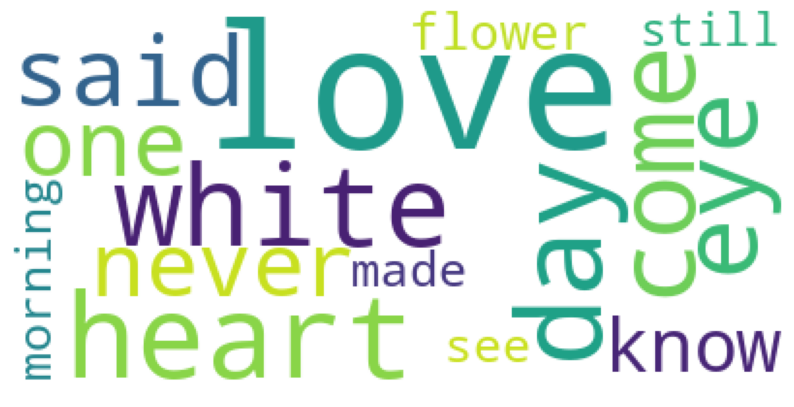

In [36]:
wordcdfun(0)

**Create word cloud for genre - death**

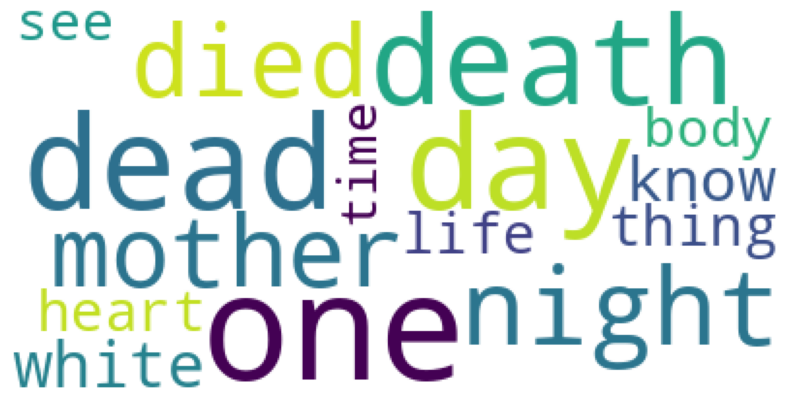

In [37]:
wordcdfun(1)

**create word cloud for genre - environment**

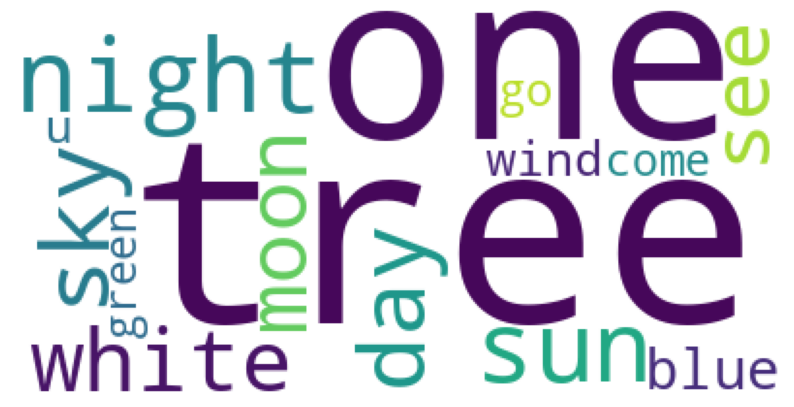

In [43]:
wordcdfun(2)

**Create word cloud for genre - music**

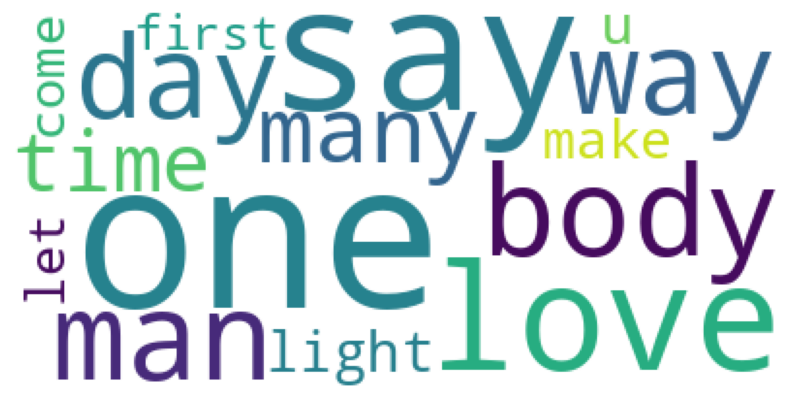

In [39]:
wordcdfun(3)

**Creating Word Cloud for all the genre**

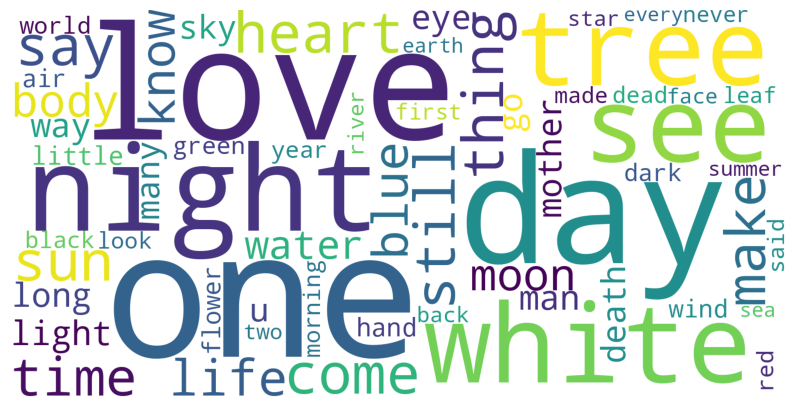

In [40]:
single_genre_text = ' '.join(df['cleaned_poem'].str.lower())

wordcloud = WordCloud(width=1600, height=800, background_color="white", max_words=60).generate(single_genre_text)

rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Naive Bayes Classifier Model**

In [41]:
print("Implementing NBC.....")
# Implementing Naive Bayes Classifier
nbc_clf = MultinomialNB()

Implementing NBC.....


In [42]:
# Running cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
acc_scores = []
prec_scores = []
recl_scores = []
f1_scores = []
iteration = 0
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    # split the data into trainset
    X_train, Y_train = data_tfidf[train_index], Y.iloc[train_index]
    # split the data into trainset
    X_test, Y_test = data_tfidf[test_index], Y.iloc[test_index]
    # Fitting NBC model
    nbc_clf.fit(X_train, Y_train)
    # predict the genre of the poem
    Y_pred = nbc_clf.predict(X_test)

    # Calculating accuracy
    acc = metrics.accuracy_score(Y_test, Y_pred)
    # Print accuracy
    print("Cross-validation accuracy: ", acc)
    # Calculating precision
    pres = metrics.precision_score(Y_test, Y_pred, average='weighted')
    # Print precision
    print("Cross-validation precision: ", pres)
    # Calculating recall
    recl = metrics.recall_score(Y_test, Y_pred, average='weighted')
    # Print precision
    print("Cross-validation recall: ", recl)
    # Calculating f1-score
    f1 = metrics.f1_score(Y_test, Y_pred, average='weighted')
    # Print f1-score
    print("Cross-validation f1-score: ", f1)

    conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
    print("Confusion Matrix:")
    print(conf_mat)

    # appending cross-validation accuracy for each iteration
    acc_scores.append(acc)
    # appending cross-validation precision for each iteration
    prec_scores.append(pres)
    # appending cross-validation recall for each iteration
    recl_scores.append(recl)
    # appending cross-validation f1-score for each iteration
    f1_scores.append(f1)
    print()
nbc_mean_accuracy = round((np.mean(acc_scores) * 100), 2)
nbc_mean_precision = round((np.mean(prec_scores) * 100), 2)
nbc_mean_recall = round((np.mean(recl_scores) * 100), 2)
nbc_mean_f1_score = round((np.mean(f1_scores) * 100), 2)
print("Metrics for Evaluating the Model:")
print("Mean cross-validation accuracy: ", nbc_mean_accuracy)
print("Mean cross-validation precision: ", nbc_mean_precision)
print("Mean cross-validation recall: ", nbc_mean_recall)
print("Mean cross-validation f1-score: ", nbc_mean_f1_score)

Iteration  1
Cross-validation accuracy:  0.40476190476190477
Cross-validation precision:  0.3251211154436961
Cross-validation recall:  0.40476190476190477
Cross-validation f1-score:  0.34794658604182416
Confusion Matrix:
[[ 0  4  5  5]
 [ 1  4  7 11]
 [ 0  2 14  7]
 [ 0  3  5 16]]

Iteration  2
Cross-validation accuracy:  0.42857142857142855
Cross-validation precision:  0.3733766233766233
Cross-validation recall:  0.42857142857142855
Cross-validation f1-score:  0.394973544973545
Confusion Matrix:
[[ 0  7  3  4]
 [ 1  8  2 12]
 [ 1  4 13  5]
 [ 1  3  5 15]]

Iteration  3
Cross-validation accuracy:  0.4166666666666667
Cross-validation precision:  0.34650997150997154
Cross-validation recall:  0.4166666666666667
Cross-validation f1-score:  0.37784366576819406
Confusion Matrix:
[[ 0  2  4  8]
 [ 0 12  5  6]
 [ 0  4 15  4]
 [ 1  9  6  8]]

Iteration  4
Cross-validation accuracy:  0.40476190476190477
Cross-validation precision:  0.36153679653679655
Cross-validation recall:  0.4047619047619047

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Code Explanation:**

The first step is retrieving the CSV file's data into the Data frame. After retrieving the data, we done the data preprocessing to improve the model's performance.

Before creating the word cloud, we cleaned the output variable, removed the HTML entities using the BeautifulSoup function, and then used a regular expression to replace the hashtags, @, URLs, and non-alphabetic characters with whitespace. Then created a new column in the data frame with a cleaned output variable. Finally, we concatenated all the values from the output variable into a single variable and converted them into lowercase using the string function.

We have created a word cloud for each genre with the frequency of the top 15 words using the Word Cloud Library. To display the word cloud diagram, we used matplotlib. Plot library. Also created a word cloud for all the genres with a total of 60 words.

Next, we created a simple classification model using the Naïve Bayes Classifier algorithm. Then we split the data into train and test data.
To evaluate the performance of the model, we used metrics like accuracy, precision, recall, and f1-score. Also, find the confusion matrix for the model. To find those metrics we used the StratifiedFold library with 10-fold cross-validation.
